Import Libraries

In [1]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Resizing, Input, Normalization
from keras.models import Sequential
from IPython import display
import matplotlib.pyplot as plt
%matplotlib widget

We donwload and extract required dataset using `pathlib` module

In [2]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)

tf.keras.utils.get_file(
    'voicedataset.zip',
    origin='http://aiolearn.com/dl/datasets/voicedata.zip',
    extract=True,
    cache_dir='.',
    cache_subdir='data'
)

print('DONE!')

DONE!


In [3]:
tf.io.gfile.listdir(str(data_dir))

['right',
 'voicedataset.zip',
 'go',
 'no',
 'left',
 'stop',
 'README.md',
 'up',
 'down',
 'yes']

Defining commands

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[(commands != 'README.md') & (commands != 'voicedataset.zip')]

print('Available Commands: ', commands )

Available Commands:  ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


Creating dataset

In [6]:
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(directory=data_dir,
                                                              batch_size=64,
                                                              validation_split=0.2,
                                                              seed=0,
                                                              output_sequence_length=16000,
                                                              subset='both')

label_names = np.array(X_train.class_names)
print()
print('label : ', label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label :  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Here, we mix and merge the sound and its label with the `squeeze` command.

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test = X_test.map(squeeze, tf.data.)

In [8]:
X_train.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
# val = X_test
X_test = X_test.shard(num_shards=2,
                   index=0)
val = X_test.shard(num_shards=2,
                   index=1)

Here, with the ‍‍‍‍`take(1)` command, the X and Y values ​​of the first patch created are displayed.

In [11]:
for x, y in X_train.take(1):
    print(x)
    print(label_names[y])

tf.Tensor(
[[ 1.4648438e-03  4.5776367e-03  2.9602051e-03 ...  3.2653809e-03
   2.5634766e-03  3.6926270e-03]
 [ 6.9885254e-03  5.8898926e-03  6.7749023e-03 ...  9.4604492e-03
   8.2092285e-03  8.0566406e-03]
 [ 0.0000000e+00  8.5449219e-04 -3.9672852e-04 ...  3.7231445e-03
  -1.2817383e-03 -3.2043457e-03]
 ...
 [-1.3122559e-03 -1.6174316e-03 -2.5329590e-03 ... -2.9602051e-03
  -2.7770996e-03 -2.4719238e-03]
 [ 6.1035156e-05  3.0517578e-05 -3.0517578e-05 ... -1.5258789e-04
   3.0517578e-05  2.1362305e-04]
 [-3.0517578e-04 -2.2277832e-03 -2.8686523e-03 ... -3.0517578e-05
   2.7465820e-04  1.0375977e-03]], shape=(64, 16000), dtype=float32)
['down' 'go' 'right' 'no' 'down' 'left' 'yes' 'go' 'stop' 'go' 'left' 'up'
 'down' 'left' 'left' 'down' 'down' 'down' 'go' 'no' 'yes' 'right' 'up'
 'down' 'down' 'no' 'up' 'up' 'go' 'yes' 'yes' 'no' 'stop' 'stop' 'up'
 'go' 'right' 'stop' 'left' 'down' 'no' 'down' 'down' 'up' 'no' 'down'
 'down' 'go' 'stop' 'yes' 'no' 'stop' 'up' 'stop' 'right' 'go' 'y

In [12]:
for example_audio, example_labels in X_train.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [14]:
label_names[[0, 1, 2]]

array(['down', 'go', 'left'], dtype='<U5')

In [15]:
example_audio[0][5100]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0009460449>

Visualizing the commands signal

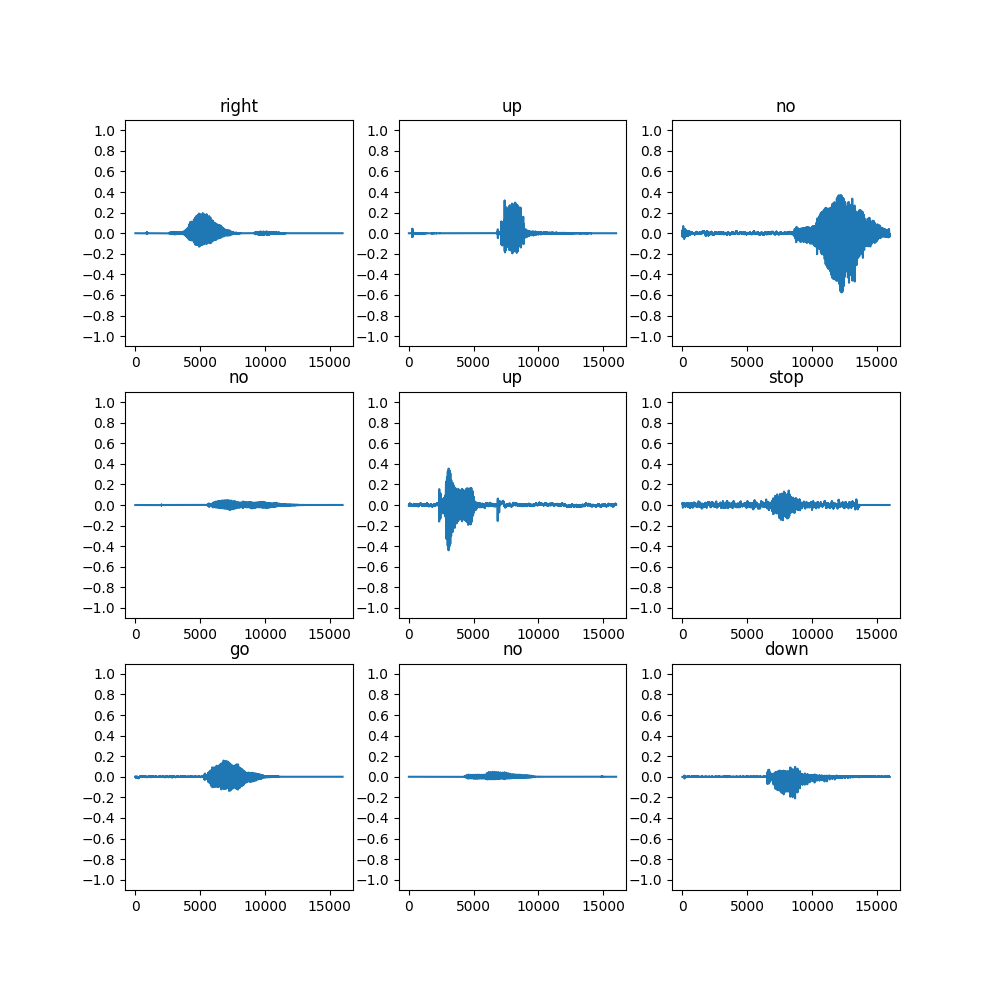

In [21]:
plt.figure(figsize=(10, 10))
rows, cols = (3, 3)
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

Now, we convert the waveform to a spectrogram via a `STFT`.

In [22]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform,
                                 frame_length=255,
                                 frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [24]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label: ', label)
    print('waveform shape: ', waveform.shape)
    print('Spectrogram shape: ', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label:  right
waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Label:  up
waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Label:  no
waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Defining a function for plotting spectrogram named `plot_spectrogram`

In [25]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Visualizing spectrogram using `plot_spectrogram` function

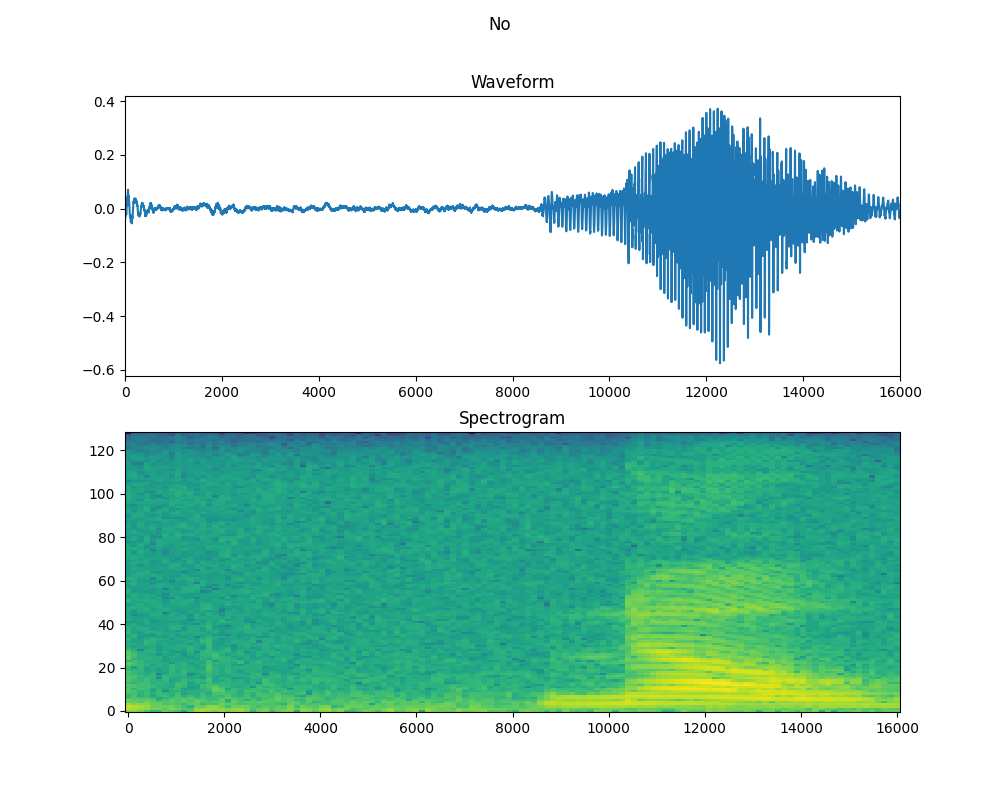

In [26]:
plt.close()
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

plt.suptitle(label.title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

Defining `make_spec_ds` Function

In [28]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls= tf.data.AUTOTUNE)